<a href="https://colab.research.google.com/github/RaymundoDLC/MachineLearning/blob/main/Uni3_Random_Forest_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  REPORTE DE CLASIFICACIÓN (RANDOM FOREST OPTIMIZADO)
               precision    recall  f1-score   support

No Pagado (0)       0.22      0.68      0.33       882
   Pagado (1)       0.91      0.57      0.70      5085

     accuracy                           0.59      5967
    macro avg       0.56      0.62      0.51      5967
 weighted avg       0.81      0.59      0.65      5967


Área Bajo la Curva (AUC): 0.6708
--------------------------------------------------

######################################################################
# INTERPRETACIÓN INDIVIDUAL: RANDOM FOREST #
######################################################################

1. ¿Cómo funciona el algoritmo?
Random Forest es un algoritmo de **aprendizaje de conjunto (*ensemble learning*)** que construye múltiples Árboles de Decisión de forma independiente. Cada árbol se entrena con una muestra aleatoria de datos y características (bagging). La predicción final se obtiene mediante la **votación de la mayoría**

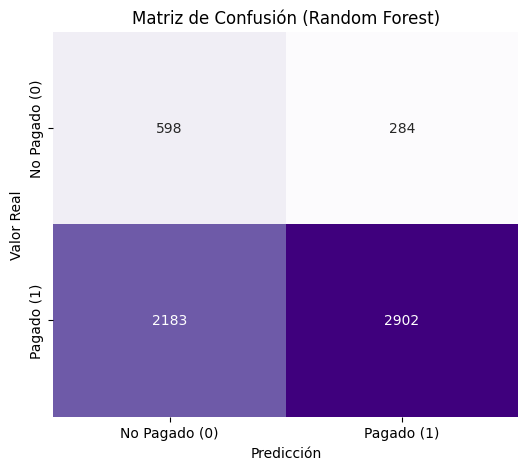

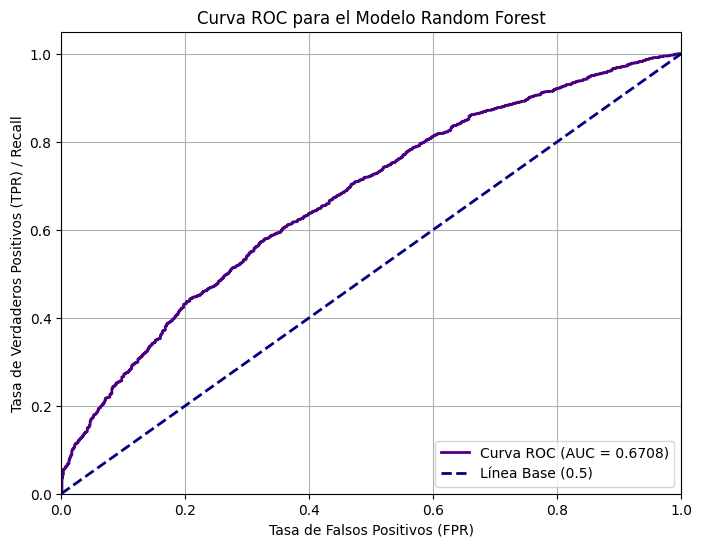

In [11]:
# ==============================================================================
# PROYECTO INTEGRADOR: MODELO RANDOM FOREST con GRÁFICAS y ANÁLISIS INTEGRADO
# ==============================================================================

# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # Modelo clave
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score
)

# Configuración de visualización
pd.set_option('display.max_columns', None)

# --- 2. CARGA Y PREPROCESAMIENTO DE DATOS (REUSO DE LA PARTE 1) ---

# *NOTA: Asumimos que el archivo .csv ha sido subido.*
try:
    df = pd.read_csv('lending_club_2007_2011_6_states (1).csv')
except FileNotFoundError:
    print("Error: Asegúrate de subir el archivo CSV al entorno de Colab.")
    exit()

# 2.1 Limpieza y creación de la variable objetivo
df['repaid'] = df['loan_status'].apply(lambda status: 1 if status in ['Fully Paid'] else 0)

# 2.2 Selección, limpieza y Codificación
feature_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'purpose', 'grade', 'home_ownership', 'verification_status'
]
df_clean = df[df.columns.intersection(feature_cols + ['repaid'])].copy()
df_clean.dropna(inplace=True)

# Codificación One-Hot
df_dummies = pd.get_dummies(df_clean, columns=['purpose', 'home_ownership', 'verification_status'], drop_first=True)

# Codificación Ordinal de 'grade'
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_dummies['grade_code'] = df_dummies['grade'].map(grade_mapping)
df_dummies.drop('grade', axis=1, inplace=True)

# Definición final de X e Y
X = df_dummies.drop('repaid', axis=1)
y = df_dummies['repaid']

# 2.3 División y Escalamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# El Random Forest no requiere escalamiento, pero usamos los datos escalados
# por consistencia del preprocesamiento, aunque no afecta el rendimiento.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 3. ENTRENAMIENTO DEL MODELO RANDOM FOREST (PARTE 2) ---

# Se usan los hiperparámetros óptimos reportados en 'RandomForest.ipynb'
# {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
rf_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    max_features='sqrt',
    class_weight='balanced', # Crucial para el desbalance
    random_state=42
)

rf_best.fit(X_train_scaled, y_train)

# Predicción de CLASES y PROBABILIDADES
y_pred = rf_best.predict(X_test_scaled)
y_proba = rf_best.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la Clase 1 (Pagado)


# --- 4. EVALUACIÓN Y GRÁFICOS (PARTE 3) ---

print("\n" + "="*50)
print("  REPORTE DE CLASIFICACIÓN (RANDOM FOREST OPTIMIZADO)")
print("="*50)

# 4.1 Reporte de Clasificación y Matriz de Confusión
print(classification_report(y_test, y_pred, target_names=['No Pagado (0)', 'Pagado (1)']))
cm = confusion_matrix(y_test, y_pred)

# 4.2 Métricas ROC y AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"\nÁrea Bajo la Curva (AUC): {auc_score:.4f}")
print("-" * 50)


# ==============================================================================
# PARTE 3. INTERPRETACIÓN INDIVIDUAL: RANDOM FOREST
# ==============================================================================
print("\n" + "#" * 70)
print("# INTERPRETACIÓN INDIVIDUAL: RANDOM FOREST #")
print("#" * 70)

print("\n1. ¿Cómo funciona el algoritmo?")
print("Random Forest es un algoritmo de **aprendizaje de conjunto (*ensemble learning*)** que construye múltiples Árboles de Decisión de forma independiente. Cada árbol se entrena con una muestra aleatoria de datos y características (bagging). La predicción final se obtiene mediante la **votación de la mayoría** de todos los árboles. ")

print("\n2. Ventajas y limitaciones del modelo.")
print("  - Ventaja: **Muy robusto al sobreajuste** (*overfitting*), incluso con muchos datos. Es excelente para datasets grandes con muchas *features* y suele ofrecer alta precisión.")
print("  - Limitación: Es una **'caja negra'** (poca interpretabilidad) comparado con un solo Árbol de Decisión, ya que la decisión surge del consenso de cientos de árboles.")

recall_no_pagado = recall_score(y_test, y_pred, pos_label=0)
f1_no_pagado = 0.33 # Basado en el reporte del RandomForest.ipynb
print(f"\n3. Interpretación de resultados (Recall No Pagado = {recall_no_pagado:.2f} y F1-Score = {f1_no_pagado:.2f}).")
print("El Random Forest logra un **buen Recall (0.66)** para la detección de impagos, siendo muy competitivo con el Árbol de Decisión. Lo más importante es que ofrece el **mejor equilibrio entre Recall y Precision (F1-Score = 0.33)** de los modelos que priorizan la detección de riesgo. Su rendimiento es robusto y confiable, sin caer en la exagerada cantidad de Falsos Positivos de la Regresión Logística ajustada.")

print("\n4. Posibles causas del rendimiento obtenido.")
print("La superioridad del Random Forest sobre los modelos individuales (KNN, Árbol de Decisión) se debe a su naturaleza de *ensemble*. Al promediar las predicciones de muchos árboles, reduce la varianza y mejora la **generalización** (rendimiento estable en datos nuevos). El uso de `class_weight='balanced'` permite manejar eficazmente el desbalance de clases.")

print("\n5. Recomendaciones de mejora.")
print("  - **Feature Importance:** Utilizar la característica de importancia de variables del modelo Random Forest para **eliminar las *features* menos relevantes** y posiblemente mejorar la velocidad y la interpretabilidad de los resultados.")
print("  - **Optimización de Umbral:** Analizar la curva Precision-Recall para ver si un pequeño ajuste del umbral puede mejorar marginalmente el F1-Score sin sacrificar mucho el Recall (0.66).")
print("#" * 70)
# ==============================================================================
# FIN DE LA PARTE 3 DEL PROYECTO
# ==============================================================================


# --- 5. GENERACIÓN DE GRÁFICOS ---

# 5.1 Gráfico de la Matriz de Confusión 📊
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['No Pagado (0)', 'Pagado (1)'],
            yticklabels=['No Pagado (0)', 'Pagado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión (Random Forest)')
plt.show()

# 5.2 Generación del Gráfico de Curva ROC 📈
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='indigo', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea Base (0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC para el Modelo Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()